0. Load libraries

In [5]:
import tensorflow as tf
import os
import sys
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
import cv2
import numpy as np
from PIL import Image
from pathlib import Path
import json
import matplotlib.pyplot as plt

1) Load the segmentation model

In [35]:
# Model path
data_root = "/mnt/c/Users/pdeschepper/Desktop/PERSONAL/DeepLearning/ImageSegmentation/Snakes_ImageSegmentation_keras/Vipera_segmentation_train_dataset_870/"
model_filename = "Vipera_SegmentationModel_V4_100+50epochs.keras"
model_history_json = "Vipera_SegmentationModel_V4_100+50epochs_traininghistory.json"
model_path = os.path.join(data_root, model_filename)
model_history_json_path = os.path.join(data_root, model_history_json)

# Import custom functions from the accessory script
sys.path.append("/mnt/c/Users/pdeschepper/Desktop/PERSONAL/DeepLearning/ImageSegmentation/Snakes_ImageSegmentation_keras/")
from HelperFuncs_IoU_DiceLoss_CombinedLoss import combined_loss, dice_loss, mean_iou

# Load model
model = load_model(
    model_path,
    custom_objects={
        'combined_loss': combined_loss,
        'dice_loss': dice_loss,
        'mean_iou': mean_iou
    } 
)

print("✅ Model loaded successfully!")
model.summary()
model.output_shape
model

✅ Model loaded successfully!
Model: "functional_1"
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 512, 512,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 512, 512,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (

<Functional name=functional_1, built=True>

# Visualize model history

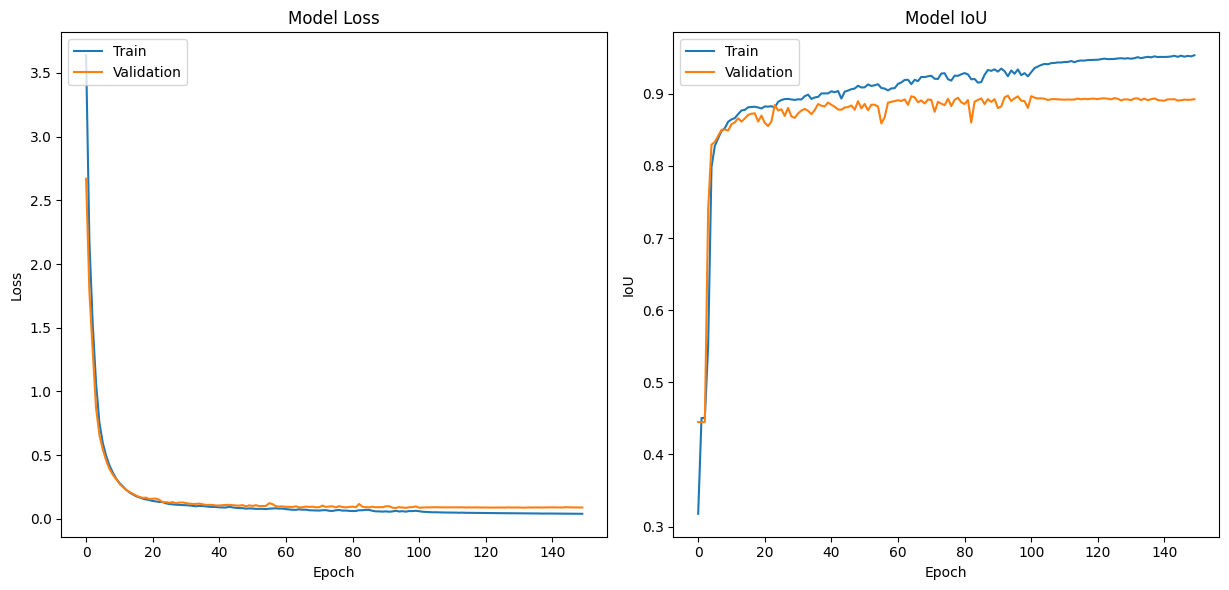

The maximum validation IoU reached is: 0.893


In [36]:
with open(model_history_json_path) as f:
    loaded_history = json.load(f)

def plot_training_history(history):
    plt.figure(figsize=(18, 6))

    # Plot training & validation loss values
    plt.subplot(1, 3, 2)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation IoU values
    plt.subplot(1, 3, 3)
    plt.plot(history['mean_iou'])
    plt.plot(history['val_mean_iou'])
    plt.title('Model IoU')
    plt.ylabel('IoU')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

plot_training_history(loaded_history)
print("The maximum validation IoU reached is: {val:.3f}".format(val=loaded_history["val_mean_iou"][-1]))


2. Segmenting and extracting the snakes, save class coverage


In [4]:
# Configuration
image_folder = r"/mnt/c/Users/pdeschepper/Desktop/Vipera_aspis_gbif_export"
output_folder = os.path.join(image_folder, "Extracted_snakes")

# Create output folder with explicit error handling
os.makedirs(output_folder, exist_ok=True)
print(f"Output folder created/verified: {output_folder}\n")

# Get list of image files
image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff'}
image_files = [f for f in os.listdir(image_folder) 
               if os.path.splitext(f)[1].lower() in image_extensions
               and not os.path.isdir(os.path.join(image_folder, f))]

print(f"Found {len(image_files)} images to process\n")

# Process all images in the list and save class coverage
output_csv_path = os.path.join(output_folder,"class_coverage.csv")
with open(output_csv_path, "w") as coverage:
    coverage.write("photo_ID,class_coverage\n")    
    for idx, img_name in enumerate(image_files, 1):
        try:
            img_path = os.path.join(image_folder, img_name)
            
            # Load original image for saving later
            img_original = Image.open(img_path).convert('RGB')
            original_size = (img_original.width, img_original.height)
            img_array = np.array(img_original)
            
            # Load and preprocess image the same way as training data
            img_resized = img_original.resize((512, 512))
            img_input = np.array(img_resized, dtype=np.uint8)
            
            # Add batch dimension
            img_input = np.expand_dims(img_input, axis=0)
            
            print(f"[{idx}] Processing {img_name}...", end=" ")
            
            # Get prediction
            mask_output = model.predict(img_input, verbose=0)
            
            # Apply argmax like in your visualization code
            mask_pred = tf.argmax(mask_output, axis=-1).numpy()
            mask_pred = mask_pred[0]
            
            # Check mask coverage
            mask_percentage = (np.sum(mask_pred == 1) / mask_pred.size) * 100
            print(f"(class 1 coverage: {mask_percentage:.1f}%)", end=" ")

            # 3. Write data using the live file handle
            coverage.write(f"{img_name},{mask_percentage:.2f}\n")
            
            # Resize mask back to original size
            mask_pil = Image.fromarray((mask_pred * 255).astype(np.uint8))
            mask_pil = mask_pil.resize(original_size, Image.NEAREST)
            mask_array = np.array(mask_pil).astype(np.float32) / 255.0
            
            # Apply mask to extract feature
            mask_expanded = np.stack([mask_array] * 3, axis=2)
            extracted_rgb = (img_array * mask_expanded).astype(np.uint8)
            
            # Create RGBA image with transparency
            extracted = np.zeros((original_size[1], original_size[0], 4), dtype=np.uint8)
            extracted[:, :, :3] = extracted_rgb
            extracted[:, :, 3] = (mask_array * 255).astype(np.uint8)
            
            # Save
            output_name = os.path.splitext(img_name)[0] + '.png'
            output_path = os.path.join(output_folder, output_name)
            result_img = Image.fromarray(extracted, 'RGBA')
            result_img.save(output_path)
            
            print(f"✓ Saved")
            
        except Exception as e:
            print(f"ERROR processing {img_name}: {e}")
            continue
            
print(f"\nProcessing complete! Results saved to: {output_folder}")

Output folder created/verified: /mnt/c/Users/pdeschepper/Desktop/Vipera_aspis_gbif_export/Extracted_snakes

Found 84 images to process

[1] Processing 5063874331_1.jpg... (class 1 coverage: 1.7%) ✓ Saved
[2] Processing 5070120342_1.jpg... (class 1 coverage: 1.4%) ✓ Saved
[3] Processing 5070120342_2.jpg... (class 1 coverage: 1.0%) ✓ Saved
[4] Processing 5070120342_3.jpg... (class 1 coverage: 0.6%) ✓ Saved
[5] Processing 5075001037_1.jpg... (class 1 coverage: 7.1%) ✓ Saved
[6] Processing 5077152431_1.jpg... (class 1 coverage: 4.4%) ✓ Saved
[7] Processing 5087318181_1.jpg... (class 1 coverage: 9.2%) ✓ Saved
[8] Processing 5087318181_2.jpg... (class 1 coverage: 10.5%) ✓ Saved
[9] Processing 5087382020_1.jpg... (class 1 coverage: 38.5%) ✓ Saved
[10] Processing 5087382020_2.jpg... (class 1 coverage: 13.2%) ✓ Saved
[11] Processing 5087382020_3.jpg... (class 1 coverage: 4.1%) ✓ Saved
[12] Processing 5087487252_1.jpg... (class 1 coverage: 7.1%) ✓ Saved
[13] Processing 5087527637_1.jpg... (class